In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import time 
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torchvision import datasets, models
from torch.utils.data import DataLoader
import torch.optim as optim

import copy

/Users/bryanvela/anaconda3/envs/ML/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # We first load the pre-trained model. We don't need any training on our end or training before/after quants.
# model = models.alexnet(pretrained=True)
# model.eval()

In [3]:
# # We have our own Linear layer
# class BFPLinear(nn.Linear):
#     def __init__(
#         self, in_features, out_features, bias=True, group_size=16, mantissa_bits=4
#     ):
#         super(BFPLinear, self).__init__(in_features, out_features, bias)
#         self.group_size = group_size
#         self.mantissa_bits = mantissa_bits

#     def forward(self, input):
#         bfp_weight = fp32_to_bfp(self.weight, self.group_size, self.mantissa_bits)
#         if self.bias is not None:
#             bfp_bias = fp32_to_bfp(self.bias, self.group_size, self.mantissa_bits)
#         else:
#             bfp_bias = None
#         return nn.functional.linear(input, bfp_weight, bfp_bias)

In [4]:
# group_size = 16
# mantissa_bits = 4
# bfp_model = BFPModelWrapper(model, group_size=group_size, mantissa_bits=mantissa_bits)
# input_data = torch.randn(1, 3, 224, 224)
# output_full_precision = bfp_model(input_data)

# bfp_model.quantize()
# output_bfp = bfp_model(input_data)

# bfp_model.restore_full_precision()
# output_full_precision_restored = bfp_model(input_data)

# print("Output (Full Precision)", output_full_precision)
# print("output (BFP): ", output_bfp)
# print("Output (restored Full Precision): "), output_full_precision_restored

In [5]:
# transform = transforms.Compose(
#     [
#         transforms.Resize(224),
#         transforms.ToTensor(),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ]
# )

In [6]:
# testset = torchvision.datasets.CIFAR10(
#     root="./data", train=False, download=True, transform=transform
# )
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=100, shuffle=False, num_workers=2
# )

In [7]:
# group_size = 16
# mantissa_bits = 4
# bfp_model = BFPModelWrapper(model, group_size=group_size, mantissa_bits=mantissa_bits)

In [8]:
# full_precision_accuracy = evaluate_model(bfp_model, testloader)
# print(f"Accuracy of the full precision model: {full_precision_accuracy}%")

In [9]:
# bfp_model.quantize()
# bfp_accuracy = evaluate_model(bfp_model, testloader)
# print(f"Accuracy of the BFP quantized model: {bfp_accuracy}%")

In [10]:
# bfp_model.restore_full_precision()
# restored_full_precision_accuracy = evaluate_model(bfp_model, testloader)
# print(
#     f"Accuracy of the restored full precision model: {restored_full_precision_accuracy}%"
# )

### Block Floating Point code, and wrapper methods

In [11]:
# This function handles quantizing a tensor to bfp
def fp32_to_bfp(tensor, group_size, mantissa_bits):
    flat_tensor = tensor.flatten()
    original_size = flat_tensor.size(0)
    padded_size = (original_size + group_size - 1) // group_size * group_size
    padded_tensor = torch.nn.functional.pad(
        flat_tensor, (0, padded_size - original_size)
    )
    padded_tensor = padded_tensor.view(-1, group_size)
    max_exponents = torch.max(padded_tensor.abs().log2().ceil(), dim=1, keepdim=True)[0]
    aligned_mantissas = padded_tensor * 2 ** (
        max_exponents - padded_tensor.abs().log2().ceil()
    )
    scale = 2**mantissa_bits
    truncated_mantissas = torch.floor(aligned_mantissas * scale) / scale
    bfp_values = truncated_mantissas * 2 ** (
        -max_exponents + padded_tensor.abs().log2().ceil()
    )
    bfp_values = bfp_values.view(-1)[:original_size]
    return bfp_values.view(tensor.shape)

In [12]:
# Quant the whole model
def quantize_model_bfp(model, group_size, mantissa_bits):
    for param in model.parameters():
        with torch.no_grad():
            param.copy_(fp32_to_bfp(param, group_size, mantissa_bits))

In [23]:
# This is for modyfing models we create (base, quant, and restored)
class BFPModelWrapper(nn.Module):
    def __init__(self, model, group_size, mantissa_bits):
        super(BFPModelWrapper, self).__init__()
        self.model = model
        self.group_size = group_size
        self.mantissa_bits = mantissa_bits
        self.full_precision_params = {
            name: param.clone().detach() for name, param in model.named_parameters()
        }

    def quantize(self):
        quantize_model_bfp(self.model, self.group_size, self.mantissa_bits)

    def restore_full_precision(self):
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                param.copy_(self.full_precision_params[name])

    def forward(self, x):
        return self.model(x)

### Methods to evaluate the models after training/loading the model 

In [14]:
class_names = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

def unnormalize(image, mean, std):
    # Reverse the normalization for visualization
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)    # Multiply by std dev and then add the mean
    return image

def evaluate_and_visualize_model(model, test_loader, device, title, class_names):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    # Define mean and std dev for unnormalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # For visualization, let's take the first image of the first batch
            if total == images.size(0):
                # Unnormalize the image for display
                image_display = images[0].cpu().clone()  # Clone to avoid changes to tensor that's in use
                image_display = unnormalize(image_display, mean, std)
                image_display = image_display.numpy().transpose((1, 2, 0))  # Rearrange dimensions to HWC for display
                image_display = np.clip(image_display, 0, 1)  # Clip values to be valid for imshow

                plt.figure(figsize=(2, 2))
                plt.imshow(image_display)
                true_label = class_names[labels[0].item()]
                predicted_label = class_names[predicted[0].item()]
                plt.title(f'{title}\nTrue: {true_label}, Pred: {predicted_label}')
                plt.show()

    accuracy = correct / total
    print(f"Accuracy with {title}: {accuracy:.4f}")


In [15]:
def average_evaluation_time(model, test_loader, device, n_runs):
    total_time = 0
    model.eval()
    with torch.no_grad():
        for _ in range(n_runs):
            # Fetch one batch of data
            for images, labels in test_loader:
                images = images.to(device)
                
                # Start timing right before the model inference
                start_time = time.time()
                
                outputs = model(images)
                
                # Stop timing right after the model inference
                elapsed_time = time.time() - start_time
                
                total_time += elapsed_time
                break  # Process only one batch per run for consistency

    average_time = total_time / n_runs
    print(f"Average prediction time over {n_runs} runs: {average_time:.6f} seconds")

In [16]:
# def average_evaluation_time(model, test_loader, device, n_runs):
#     total_time = 0
#     for _ in range(n_runs):
#         start_time = time.time()
#         accuracy = evaluate_model_for_timing(model, test_loader, device)
#         elapsed_time = time.time() - start_time
#         total_time += elapsed_time
#         print(f"Run took {elapsed_time:.3f} seconds with accuracy: {accuracy:.4f}")

#     average_time = total_time / n_runs
#     print(f"Average evaluation time over {n_runs} runs: {average_time:.3f} seconds")


In [17]:
def evaluate_model_for_timing(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


In [81]:
def evaluate_bfp_model(bfp_model, test_loader, device):
    bfp_model.to(device)
    bfp_model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = bfp_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy
    #print(f"Accuracy of the BFP quantized model: {accuracy:.4f}")


In [86]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)
    
    total_accuracy = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_accuracy += accuracy(outputs, labels) * images.size(0)
            total_samples += images.size(0)
    
    return 100 * total_accuracy / total_samples


### Train and fine-tune the ResNet18 model for the CIFAR-10 Dataset (takes 1 hour on MAC M1 MPS GPU, proceed below to load model and skip this)

In [ ]:
from transformers import GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer

import torch
print("hi 1")
# Ensure the device uses MPS if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu" # torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("hi 2")
# Load tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B")

print("hi 3")
# Move the model to MPS device
model.to(device)
print("hi 4")
# Example usage
input_text = "The future of AI in healthcare is"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
print("hi 5")
# Generate text
output = model.generate(input_ids, max_length=50)
print("hi 6")
# Decode and print the generated text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


hi 1
hi 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


hi 3
hi 4
hi 5


In [20]:
# Load the pretrained ResNet model
model = models.resnet18(pretrained=True)

# Replace the final layer to match CIFAR-10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Prepare the CIFAR10 dataset and do the required transforms
transform = transforms.Compose([
    transforms.Resize(256),  # Resize 
    transforms.CenterCrop(224),  # Crop to the size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR10
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Move model to GPU if available (make sure to change this if not on mac lol)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)
model.to(device)

# Train the model and save the best model based on loss (Takes 1 Hour)
model.train()  # Set the model to training mode
num_epochs = 10
min_loss = float('inf')

start_time = time.time()  # Start timing the training process

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Time the start of the epoch
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            current_loss = running_loss / 200
            print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss {current_loss:.3f}')
            if current_loss < min_loss:
                min_loss = current_loss
                # Save the model if the current batch loss is the lowest encountered
                torch.save(model.state_dict(), 'best_model_state.pth')
            running_loss = 0.0

    epoch_duration = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1} completed in {epoch_duration:.2f} seconds')

total_training_time = time.time() - start_time
print(f'Training completed in {total_training_time:.2f} seconds')

full_precision_accuracy = evaluate_model(model, test_loader)
print(f"Accuracy of the full precision model: {full_precision_accuracy}%")

/Users/bryanvela/anaconda3/envs/ML/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bryanvela/anaconda3/envs/ML/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Using device: mps


KeyboardInterrupt: 

### Load the model to skip training entirely

In [21]:
# Flag to control model loading
load_model = True

if load_model:
    # Load the model state
    model.load_state_dict(torch.load('best_model_state.pth'))
    model.eval()  # Set the model to evaluation mode
    print("Model loaded successfully and set to evaluation mode.")
else:
    print("Model loading skipped.")

Model loaded successfully and set to evaluation mode.


### Evaluate the model for inference, etc 

In [41]:
full_precision_accuracy = evaluate_model(model, test_loader, device)
print(f"Accuracy of the full precision model: {full_precision_accuracy:.4f}")

Accuracy of the full precision model: 0.9427


In [35]:
def test_model_precision(model, test_loader, device, dtype):
    try:
        # Clone the model to ensure each test is independent
        test_model = copy.deepcopy(model)

        # Convert the cloned model to the specified precision
        test_model.to(device=device, dtype=dtype)
        test_model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device=device, dtype=dtype), labels.to(device)
                outputs = test_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Accuracy with {dtype}: {accuracy:.4f}")
    except TypeError as e:
        print(f"Error converting model to {dtype}: {e}")


# Load the original model and set it to evaluation mode
original_model = models.resnet18(pretrained=False)
num_ftrs = original_model.fc.in_features
original_model.fc = nn.Linear(num_ftrs, 10)
original_model.load_state_dict(torch.load('best_model_state.pth'))
original_model.to(device)  # Move the original model to the specified device

# Load the test set
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Test the model with different precision types
test_model_precision(original_model, test_loader, device, torch.float32)  # Original single-precision float
test_model_precision(original_model, test_loader, device, torch.float16)  # Half-precision
test_model_precision(original_model, test_loader, device, torch.bfloat16)  # Brain floating-point precision

Files already downloaded and verified
Accuracy with torch.float32: 0.9427
Accuracy with torch.float16: 0.9425
Accuracy with torch.bfloat16: 0.9422


### Rerun this cell below before testing different BFP hyperapatemres (group size, mantissa, etc) since otherwise I kept getting issues of repeated accuracy even after hyperparamter changes

In [82]:
# Load the original model and set it to evaluation mode
original_model = models.resnet18(pretrained=False)
num_ftrs = original_model.fc.in_features
original_model.fc = nn.Linear(num_ftrs, 10)
original_model.load_state_dict(torch.load('best_model_state.pth'))
original_model.to(device)  # Move the original model to the specified device

# Load the test set
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [61]:
# Load the original model and set it to evaluation mode
original_model = models.resnet18(pretrained=False)
num_ftrs = original_model.fc.in_features
original_model.fc = nn.Linear(num_ftrs, 10)
original_model.load_state_dict(torch.load('best_model_state.pth'))
original_model.to(device)  # Move the original model to the specified device

# Load the test set
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def anamoly_detection_swap(model_wrapper, test_loader, device, n):
    model_wrapper.to(device)
    model_wrapper.eval()
    
    consecutive_errors = 0
    consecutive_corrects = 0
    using_quantized = True
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_wrapper(images)
            _, predicted = torch.max(outputs, 1)
            for idx in range(images.size(0)):
                if predicted[idx] == labels[idx]:
                    consecutive_errors = 0
                    consecutive_corrects += 1
                    correct += 1
                else:
                    consecutive_corrects = 0
                    consecutive_errors += 1

                # Check if we need to switch model precision
                if using_quantized and consecutive_errors > n:
                    model_wrapper.restore_full_precision()
                    using_quantized = False
                    print(f"Switched to full precision due to {n} errors.")
                    consecutive_errors = 0  # Reset counter after switching
                elif not using_quantized and consecutive_corrects > n:
                    model_wrapper.quantize()
                    using_quantized = True
                    print(f"Switched back to quantized model after {n} correct classifications.")
                    consecutive_corrects = 0  # Reset counter after switching

                total += 1

    accuracy = correct / total
    print(f"Final accuracy: {accuracy:.4f}. Final swap finished with: {'quantized' if using_quantized else 'full precision'} model")

bfp_model = BFPModelWrapper(original_model, group_size=8, mantissa_bits=9)
bfp_model.quantize()  # Start with the quantized model

anamoly_detection_swap(bfp_model, test_loader, device, n=3)

Files already downloaded and verified
Switched to full precision due to 4 errors.
Switched back to quantized model after 4 correct classifications.
Switched to full precision due to 4 errors.
Switched back to quantized model after 4 correct classifications.
Final accuracy: 0.7743. Final swap finished with: quantized model


Accuracy for group size 2: 0.40%
Accuracy for group size 4: 0.64%
Accuracy for group size 8: 0.77%
Accuracy for group size 12: 0.82%
Accuracy for group size 16: 0.84%
Accuracy for group size 20: 0.86%
Accuracy for group size 24: 0.87%
Accuracy for group size 28: 0.88%
Accuracy for group size 32: 0.88%
Accuracy for group size 36: 0.89%
Accuracy for group size 40: 0.89%
Accuracy for mantissa bits 1: 0.10%
Accuracy for mantissa bits 2: 0.09%
Accuracy for mantissa bits 3: 0.09%
Accuracy for mantissa bits 4: 0.10%
Accuracy for mantissa bits 5: 0.09%
Accuracy for mantissa bits 6: 0.10%
Accuracy for mantissa bits 7: 0.14%
Accuracy for mantissa bits 8: 0.19%
Accuracy for mantissa bits 9: 0.78%
Accuracy for mantissa bits 10: 0.92%
Accuracy for mantissa bits 11: 0.94%
Accuracy for mantissa bits 12: 0.94%
Accuracy for mantissa bits 13: 0.94%
Accuracy for mantissa bits 14: 0.94%
Accuracy for mantissa bits 15: 0.94%
Accuracy for mantissa bits 16: 0.94%
Accuracy for mantissa bits 17: 0.94%
Accuracy 

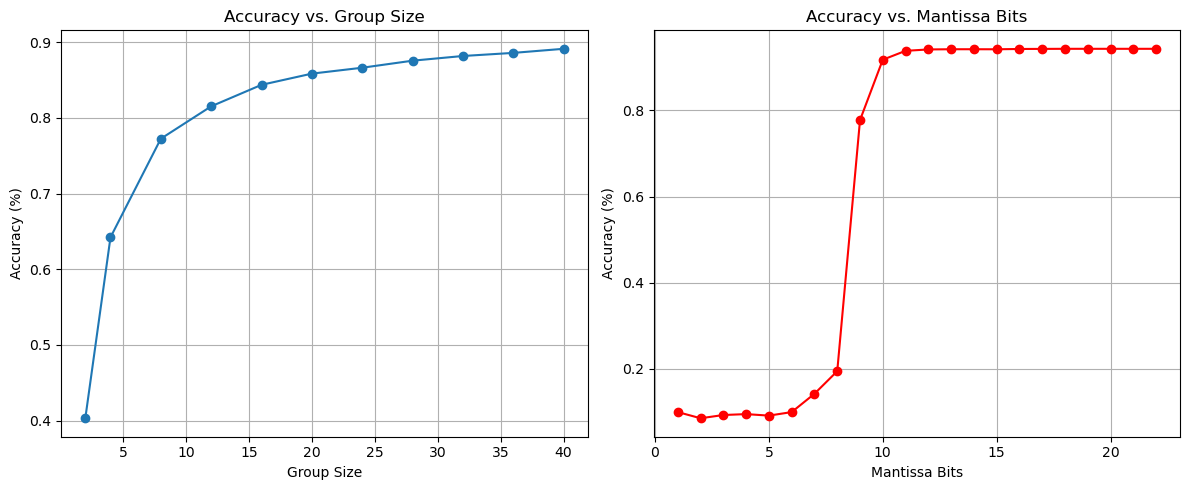

In [88]:
# Variables to store results
group_sizes = [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
mantissa_bits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
group_size_accuracies = []
mantissa_accuracies = []

# Test for different group sizes
for i in group_sizes:
    original_model = models.resnet18(pretrained=True)
    num_ftrs = original_model.fc.in_features
    original_model.fc = nn.Linear(num_ftrs, 10)
    original_model.load_state_dict(torch.load('best_model_state.pth'))
    original_model.to(device)

    bfp_model = BFPModelWrapper(original_model, group_size=i, mantissa_bits=9)
    bfp_model.quantize()
    bfp_model.model.to(device)

    accuracy = evaluate_bfp_model(bfp_model, test_loader, device)
    group_size_accuracies.append(accuracy)
    print(f"Accuracy for group size {i}: {accuracy:.2f}%")

# Test for different mantissa bits
for bits in mantissa_bits:
    original_model = models.resnet18(pretrained=True)
    num_ftrs = original_model.fc.in_features
    original_model.fc = nn.Linear(num_ftrs, 10)
    original_model.load_state_dict(torch.load('best_model_state.pth'))
    original_model.to(device)

    bfp_model = BFPModelWrapper(original_model, group_size=9, mantissa_bits=bits)
    bfp_model.quantize()
    bfp_model.model.to(device)

    accuracy = evaluate_bfp_model(bfp_model, test_loader, device)
    mantissa_accuracies.append(accuracy)
    print(f"Accuracy for mantissa bits {bits}: {accuracy:.2f}%")

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(group_sizes, group_size_accuracies, marker='o')
plt.title('Accuracy vs. Group Size')
plt.xlabel('Group Size')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mantissa_bits, mantissa_accuracies, marker='o', color='red')
plt.title('Accuracy vs. Mantissa Bits')
plt.xlabel('Mantissa Bits')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

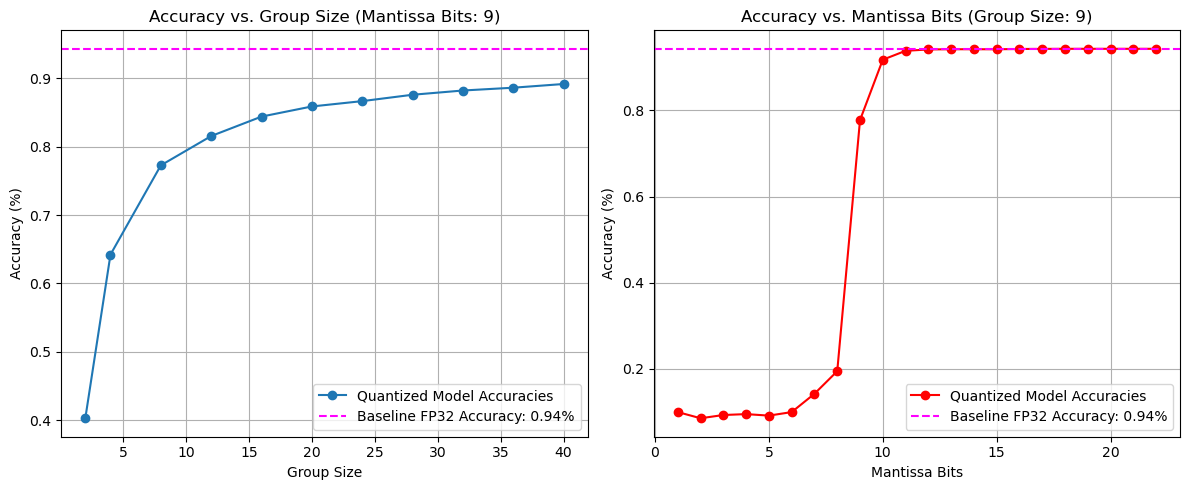

In [101]:
import matplotlib.pyplot as plt

# Assuming baseline accuracy of the full FP32 model
baseline_accuracy = 0.9427  # Convert to percentage for consistency with other accuracy values

# Plotting results with baseline accuracy
plt.figure(figsize=(12, 5))

# Plot for Group Size
plt.subplot(1, 2, 1)
plt.plot(group_sizes, group_size_accuracies, marker='o', label='Quantized Model Accuracies')
plt.axhline(y=baseline_accuracy, color='magenta', linestyle='--', label=f'Baseline FP32 Accuracy: {baseline_accuracy:.2f}%')
plt.title('Accuracy vs. Group Size (Mantissa Bits: 9)')
plt.xlabel('Group Size')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend(loc='best')  # Adjust legend location as needed

# Plot for Mantissa Bits
plt.subplot(1, 2, 2)
plt.plot(mantissa_bits, mantissa_accuracies, marker='o', color='red', label='Quantized Model Accuracies')
plt.axhline(y=baseline_accuracy, color='magenta', linestyle='--', label=f'Baseline FP32 Accuracy: {baseline_accuracy:.2f}%')
plt.title('Accuracy vs. Mantissa Bits (Group Size: 9)')
plt.xlabel('Mantissa Bits')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend(loc='best')

plt.tight_layout()
plt.show()


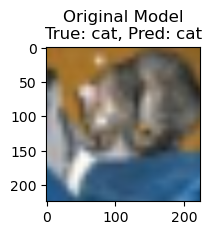

Accuracy with Original Model: 0.9427


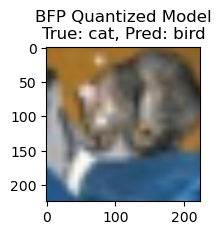

Accuracy with BFP Quantized Model: 0.3529


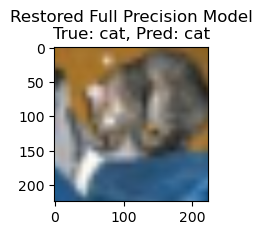

Accuracy with Restored Full Precision Model: 0.9427


In [71]:
def get_model_size(model):
    total_size = 0
    for param in model.parameters():
        total_size += param.numel() * param.element_size()  # num_elements * size_per_element in bytes
    return total_size

def estimate_quantized_model_size(model, bits_per_param):
    total_size_bits = 0
    for param in model.parameters():
        total_size_bits += param.numel() * bits_per_param
    total_size_bytes = total_size_bits / 8
    return total_size_bytes


def print_param_info(model, message):
    print(message)
    for name, param in model.named_parameters():
        print(f"{name}: dtype={param.dtype}, size={param.storage().size()}")
        break  # Remove this line to see all parameters


test_fp32 = copy.deepcopy(original_model)
test_fp16 = copy.deepcopy(original_model)
test_bfloat = copy.deepcopy(original_model)

# Calculate model size in FP32
fp32_size = get_model_size(test_fp32)
#print(f"Model size in FP32: {fp32_size / (1024 ** 2):.2f} MB")


# Convert model to FP16 and calculate size
model_fp16 = test_fp16.half()
fp16_size = get_model_size(model_fp16)
#print(f"Model size in FP16: {fp16_size / (1024 ** 2):.2f} MB")


# Convert model to BFLOAT16 and calculate size
if device == torch.device('mps'):  # BFLOAT16 is supported on CUDA
    model_bfloat16 = test_bfloat.to(dtype=torch.bfloat16)
    bfloat16_size = get_model_size(model_bfloat16)
    #print(f"Model size in BFLOAT16: {bfloat16_size / (1024 ** 2):.2f} MB")
else:
    print("BFLOAT16 is not supported on CPU")



#print_param_info(original_model, "Before Quantization")
#original_size_bytes = estimate_quantized_model_size(original_model, 32)
#print(f"Original Model Size: {original_size_bytes / (1024 ** 2):.4f} MB")
# Evaluate and visualize the original model
evaluate_and_visualize_model(original_model, test_loader, device, "Original Model", class_names)

# BFP Model evaluation
bfp_model = BFPModelWrapper(original_model, group_size=20, mantissa_bits=8)
start_quant_timer = time.time()
bfp_model.quantize()
#print("Quantizig the model took: ", time.time() - start_quant_timer)
evaluate_and_visualize_model(bfp_model, test_loader, device, "BFP Quantized Model", class_names)
#print_param_info(bfp_model.model, "After Quantization")  # Assuming bfp_model has an accessible model attribute
# Estimate size assuming 9 bits per parameter
#quantized_size_bytes = estimate_quantized_model_size(original_model, 9)
#print(f"Estimated Quantized Model Size using {9} mantissa bits: {quantized_size_bytes / (1024 ** 2):.4f} MB")

# Restore and evaluate the full precision model
start_restore_timer = time.time()
bfp_model.restore_full_precision()
#print("Restoring the model took: ", time.time() - start_restore_timer)
evaluate_and_visualize_model(bfp_model, test_loader, device, "Restored Full Precision Model", class_names)
#print_param_info(bfp_model.model, "After Restoration")

### Block Floating Point Testing

In [32]:
# Test the BFP model
bfp_model = BFPModelWrapper(original_model, group_size=16, mantissa_bits=10)

# Quantize the model to BFP
bfp_model.quantize()

# Evaluate the BFP model
evaluate_bfp_model(bfp_model, test_loader, device)

Accuracy of the BFP quantized model: 0.9255


In [52]:
# Optionally, restore to full precision to compare or reuse the model
bfp_model.restore_full_precision()
full_precision_accuracy = evaluate_bfp_model(bfp_model, test_loader, device)

Accuracy of the BFP quantized model: 0.9427


In [48]:
full_precision_accuracy = evaluate_model(original_model, test_loader, device)
print(f"Accuracy of the original model: {full_precision_accuracy:.4f}")

bfp_model.quantize()
full_precision_accuracy = evaluate_model(bfp_model, test_loader, device)
print(f"Accuracy of the bfp model: {full_precision_accuracy:.4f}")

Accuracy of the original model: 0.9427
Accuracy of the bfp model: 0.1000


In [49]:
# # Load and prepare models and data as needed (assume these are set up)
# n_evaluations = 100
# average_evaluation_time(original_model, test_loader, device, n_evaluations)
# average_evaluation_time(bfp_model, test_loader, device, n_evaluations)
# Example usage
print("Timing the original model:")
average_evaluation_time(original_model, test_loader, device, 1000)

print("Timing the BFP quantized model:")
average_evaluation_time(bfp_model, test_loader, device, 1000)

Timing the original model:
Average prediction time over 1000 runs: 0.004386 seconds
Timing the BFP quantized model:
Average prediction time over 1000 runs: 0.004543 seconds
